![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: Attention Maps for Text

This Notebook shows how to produce attention maps for textual data. 

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-transformer/Tutorial_attention_map_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
A folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also receive an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-for-1d-data


### Imports, data and model loading

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


In [ ]:
weights_path = "../data_and_models/t5_small_weights"


In [ ]:
!mkdir ../data_and_models/t5_small_weights/
!curl -L "https://www.dropbox.com/scl/fi/r3zc8w4551l9nyq08cnso/t5.zip?rlkey=vcwmz0cuzx80irainvsfs8gsm&dl=0" > ../data_and_models/t5_small_weights/t5_small.zip
!unzip ../data_and_models/t5_small_weights/t5_small.zip -d ../data_and_models/t5_small_weights/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    379      0 --:--:-- --:--:-- --:--:--   379
100   491    0   491    0     0    312      0 --:--:--  0:00:01 --:--:--     0
100  642M  100  642M    0     0  16.5M      0  0:00:38  0:00:38 --:--:-- 19.3M


In [ ]:
# Function that plot the attention map
def showAttention(input_sentence, output_words, attentions):
    fig, ax = plt.subplots(figsize=(20,5))
    cax = ax.matshow(attentions.detach().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([" "] + input_sentence, rotation=90)
    ax.set_yticklabels([" "] + output_words)
    # ax.set_yticklabels([''] + output_words)
    # Show label at every tick

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


We have fine-tuned a sequence-to-sequence model using the huggingface library to translate English to French. Let's load our fine-tuned model as well as our tokenizer. 

In [6]:
model = AutoModelForSeq2SeqLM.from_pretrained(weights_path)
tokenizer = AutoTokenizer.from_pretrained(weights_path)


/p/project/hai_squi4mi/benassou1/Squiggle-Project2/sc_venv_template/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Now let's translate a sentence from English to French: 

In [7]:
text = "translate from English to French: I want to go to the cinema."


Let's generate the tokens for the input.

In [8]:
inputs = tokenizer(text, return_tensors="pt")
inputs


{'input_ids': tensor([[13959,    45,  1566,    12,  2379,    10,    27,   241,    12,   281,
            12,     8, 10276,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The `input` variable is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. The attention_mask is a tensor that indicates which tokens should be attended to and which should not. It is usually a sequence of 1s and 0s: a 1 for each real token in input_ids and a 0 for padding tokens (if any). This tells the model to pay attention to the input tokens and ignore the padding in cases where sequences are padded to a fixed length for batched processing.

We generate the corresponding French translation of our English sentence. We can then generate the self-attention of the encoder, decoder, and cross attention.

In [9]:
output = model.generate(inputs.input_ids, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
attention = model(**inputs, labels=output, output_attentions=True)

cross_attention = attention.cross_attentions
encoder_attention = attention.encoder_attentions
decoder_attention = attention.decoder_attentions


We can decode the input_ids of the input and output to generate their corresponding tokens 

In [10]:
decoded_input = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
decoded_input


['▁translate',
 '▁from',
 '▁English',
 '▁to',
 '▁French',
 ':',
 '▁I',
 '▁want',
 '▁to',
 '▁go',
 '▁to',
 '▁the',
 '▁cinema',
 '.',
 '</s>']

In [11]:
decoded_output = tokenizer.convert_ids_to_tokens(output[0])
decoded_output


['<pad>',
 '▁Moi',
 ',',
 '▁je',
 '▁',
 'veux',
 '▁partir',
 '▁au',
 '▁cinéma',
 '.',
 '</s>']

## **Self-Attention**

We average the heads of the last encoder layer and plot it

/tmp/ipykernel_10929/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_10929/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


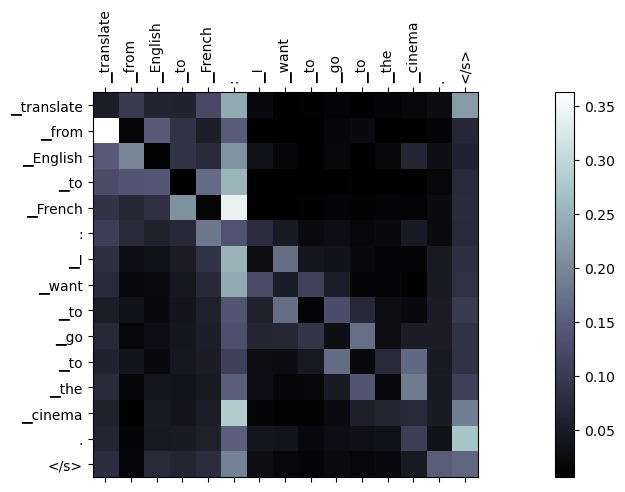

In [12]:
avg_encoder_attention = torch.stack(encoder_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_input, decoded_input, avg_encoder_attention)


- Since this is the last encoder layer, the self-attention mechanism highlights how each word (or subword) in the input sequence attends to every other word (or subword). This is important for encoding the context around each word.
- Lighter squares indicate higher average attention weights, suggesting that the model is considering those input positions more when encoding the word for translation.
Darker squares indicate lower average attention weights, suggesting that the model is less focused on those input positions when encoding the word.
- If you see a strong diagonal line of lighter squares, it means that words are mostly attending to themselves and their immediate neighbors, which is typical as words often have the most context with adjacent words.
- Off-Diagonal Attention**: Lighter squares away from the diagonal could indicate that the model is capturing long-range dependencies within the input sequence, which is crucial for understanding the full context of the sentence.
- Special Tokens**: Attention to special tokens like "<s>" and "</s>" can indicate how the model handles the beginning and end of the input sequence.
- Contextual Relationships**: By looking at which tokens have lighter squares in their row, you can infer which tokens are considered most important for understanding the context of other tokens.


We can generate the same plots but for the decoder side.

/tmp/ipykernel_10929/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_10929/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


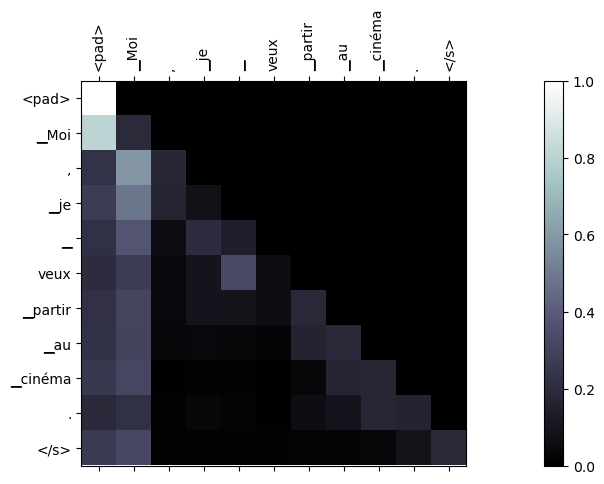

In [13]:
avg_decoder_attention = torch.stack(decoder_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_output, decoded_output, avg_decoder_attention)


This attention map is displayed using the attention weights. The attention weights are calculated within a single sequence to model the interactions between different elements of that sequence. The process involves queries, keys, and values, all of which are derived from the same input data. Here's a step-by-step explanation of how these weights are calculated:

1. **Linear Transformations**: Each element (like a word in a sentence) of the input sequence is transformed into three vectors: a query vector ($ Q$), a key vector ($ K$), and a value vector ($ V$). These transformations are usually done using different learned linear layers (or affine transformations).

2. **Score Calculation**: For each element of the sequence, scores are calculated by taking the dot product of its query vector with the key vector of every other element in the sequence. The score $ \text{score}(i, j)$ represents the influence of the $ j$-th element on the $ i$-th element. The formula is:

$
    \text{score}(Q_i, K_j) = Q_i \cdot K_j^T 
$

3. **Scaling**: The scores are often scaled down by the square root of the dimension of the key vectors ($ \sqrt{d_k}$). This is done to stabilize the gradients during training. So, the scaled score is:

$
    \text{scaled score}(Q_i, K_j) = \frac{Q_i \cdot K_j^T}{\sqrt{d_k}} 
$

4. **Softmax Normalization**: Apply the softmax function to the scaled scores for each query. This step converts the scores to a probability distribution (the attention weights), ensuring that they are all positive and sum up to 1:

$
    \alpha_{ij} = \text{softmax}(\text{scaled score}(Q_i, K_j)) = \frac{\exp(\text{scaled score}(Q_i, K_j))}{\sum_{k=1}^{n} \exp(\text{scaled score}(Q_i, K_k))} 
$

   Here, $ \alpha_{ij}$ represents the attention weight from the $ i$-th query to the $ j$-th key.



## **Cross-Attention**

In cross-attention, the attention mechanism considers two different sequences. In our example, one sequence is the source sentence (the English sentence), and the other is the target sentence (the translated sentence).
A cross-attention map visualizes how elements of one sequence (English sentence) are attended to when processing each element of the other sequence (say, the target sentence). In other words, how much did each input token contribute to generating each output token?

To plot the cross attention, we average the heads of the last attention layer of the model and plot it.

/tmp/ipykernel_10929/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_10929/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


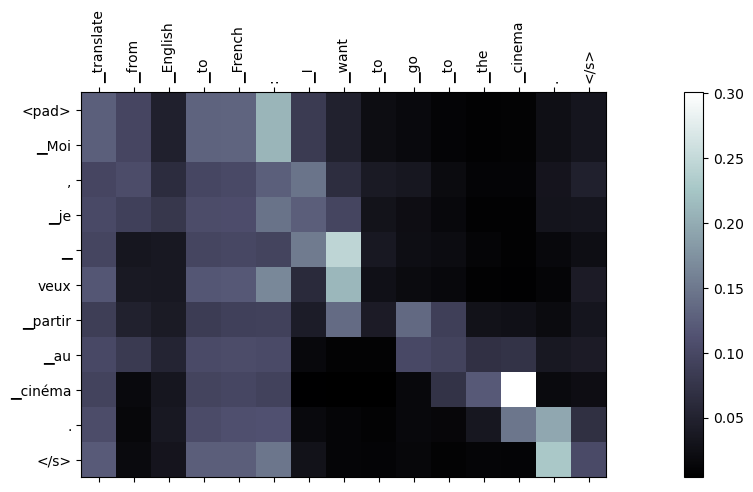

In [14]:
avg_attention = torch.stack(cross_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_input, decoded_output, avg_attention)


In our example, you can see that there is a high correlation between the tokens "cinema" and "Cinéma" and no correlation between "want" and "Cinéma" for example.

# **How Does it Work**

Here's how cross-attention weights are typically generated:

1. **Preparation of Queries, Keys, and Values**:
   - In cross-attention, the queries ($ Q $) are derived from one sequence, such as the current state of the decoder in a machine translation model. The keys ($ K $) and values ($ V $) are derived from another sequence, like the encoder's output. These vectors are obtained through learned linear transformations from their respective input data.

2. **Score Calculation**:
   - The model calculates scores between each query and all keys. These scores represent the relevance of each element in the key sequence to the respective query. The calculation commonly uses the dot product: $ \text{Score}(Q, K) = QK^T $. This dot product measures the compatibility between queries and keys.

3. **Scaling**:
   - The scores are scaled by the square root of the dimension of the keys ($ \sqrt{d_k} $). This scaling is performed to stabilize the gradients during training. The scaled score becomes: $ \text{Scaled Score} = \frac{QK^T}{\sqrt{d_k}} $.

4. **Softmax Normalization**:
   - The softmax function is applied to these scaled scores across the keys for each query. This normalization process transforms the scores into a set of attention weights: $ A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) $. These attention weights determine the extent to which each element in the key sequence is considered when constructing the output for each query.

The attention weights matrix $ A $ obtained from these steps is used to create cross-attention maps. Each matrix element, $ A_{ij} $, represents the attention weight from the $ i $-th element of the query sequence to the $ j $-th element of the key sequence. These maps visually demonstrate how the model attends to different parts of one sequence (represented by keys) in relation to each part of another sequence (represented by queries), thus providing insight into the model's learning and decision-making process.

## References

[1] https://huggingface.co/docs/transformers/index